##  <span style='color:green '>Evaluate Models</scan>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import joblib
import warnings
warnings.filterwarnings('ignore')
import nfl_data_py as nfl

###  <span style='color:green '> Set up variables to be used in Fit Determination Function</scan>

In [2]:
index = []
scores = {'Train Score': [], "Test Score": [], 'Test Train Difference': [], 'Scaler': []}
scalers = ["none", StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()]
models = [LinearRegression(),
          LogisticRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(),
          RandomForestClassifier(),
          ExtraTreesRegressor(),
          ExtraTreesClassifier(),
          AdaBoostRegressor(),
          AdaBoostClassifier()]

###  <span style='color:green '>Define Function to Test Models and Scalers</scan>

In [3]:
def test_model(data):
    for scaler in scalers:
        global index
        global scores
        if scaler != "none":
            scaler.fit(X_train)
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test
        data = X_train_scaled, X_test_scaled, y_train, y_test
        for model in models:
            reg = model.fit(X_train_scaled, y_train)
            y_pred = reg.predict(X_test_scaled)
            scores["Train Score"].append(reg.score(X_train_scaled, y_train))
            scores["Test Score"].append(reg.score(X_test_scaled, y_test))
            scores["Test Train Difference"].append((reg.score(X_train_scaled, y_train)-(reg.score(X_test_scaled, y_test))))
            scores["Scaler"].append(scaler)
            index += [type(reg).__name__]

###  <span style='color:green '>Get data and evaluate readiness for model</scan>

 <span style='color:green '>* Find features and target 
     * Test for imbalance </scan>

In [4]:
nfl.see_pbp_cols()
pbp2021 = nfl.import_pbp_data(years=[2021], downcast=True, cache=False, alt_path=None)
pbp2021


# load additional team data 
pbpclean = pbp2021
teams = nfl.import_team_desc()
players = nfl.import_rosters([2021])
player_seasons = nfl.import_seasonal_data([2021])
player_seasons.head(5)

adp = pd.read_csv('Resources/ADPxFinal.csv') 
adp_scope = adp[['Player',
                 '2019 FantasyPoints',
                 '2020 FantasyPoints',
                 '2021 FantasyPoints',
                 'Production21',
                 'Average Total Production',
                 'Team',
                 'POS',
                 'AVG'
                ]].copy()

2021 done.
Downcasting floats.


In [5]:
# Correct "inf" and "-inf" values 
# Replace infinite updated data with drop
# drop these rows from what will become our result set 
adp_scope.replace([np.inf, -np.inf], "drop", inplace=True)
res = adp_scope[~adp_scope.eq('drop').any(1)]
adp_scope  = res
adp_scope

,Player,2019 FantasyPoints,2020 FantasyPoints,2021 FantasyPoints,Production21,Average Total Production,Team,POS,AVG
0,Jonathan Taylor,0.0,217.0,333.0,97.250653,59.723157,IND,RB1,1.0
1,Austin Ekeler,309.0,111.0,274.0,84.16,79.979791,LAC,RB2,3.0
2,Cooper Kupp,270.5,117.0,295.0,100.229167,84.274732,LAR,WR1,3.5
3,Derrick Henry,294.6,314.0,175.0,36.853556,67.397175,TEN,RB3,3.8
4,Christian McCaffrey,469.2,73.0,91.0,39.35,47.962044,CAR,RB4,4.0
...,...,...,...,...,...,...,...,...,...
509,Ethan Wolf,0.0,0.0,1.0,4.0,1.333333,NaN,NaN,NaN
510,Nick Boyle,75.1,23.0,0.0,3.333333,35.519423,NaN,NaN,NaN
511,Darrell Daniels,1.4,15.0,0.0,0.0,23.245614,NaN,NaN,NaN
512,Daniel Helm,0.0,0.0,0.0,-3.0,-1.0,NaN,NaN,NaN


In [6]:
adp

,Unnamed: 0,Player,2021 Tm,Age,2021 Games,2021 GS,2021 Tgt,2021 Rec,2021 RushingYds,2021 RushingTD,...,Usage21,Touchdowns21,TotYdsScrm21,Production21,Average Total Usage,Average Total Yards,Average Total Production,Team,POS,AVG
0,227,Jonathan Taylor,IND,22.0,17,17,51.0,40.0,1811.0,18.0,...,22.529412,20.0,2171.0,97.250653,13.532026,1213.000000,59.723157,IND,RB1,1.0
1,228,Austin Ekeler,LAC,26.0,16,16,94.0,70.0,911.0,12.0,...,18.750000,20.0,1558.0,84.160000,17.283333,1347.000000,79.979791,LAC,RB2,3.0
2,0,Cooper Kupp,LAR,28.0,17,17,191.0,145.0,18.0,0.0,...,19.764706,16.0,1965.0,100.229167,16.138235,1379.000000,84.274732,LAR,WR1,3.5
3,240,Derrick Henry,TEN,27.0,8,8,20.0,18.0,937.0,10.0,...,29.875000,10.0,1091.0,36.853556,25.745833,1659.333333,67.397175,TEN,RB3,3.8
4,269,Christian McCaffrey,CAR,25.0,7,7,41.0,37.0,442.0,1.0,...,20.000000,2.0,785.0,39.350000,24.270833,1183.666667,47.962044,CAR,RB4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,509,Ethan Wolf,NOR,26.0,2,1,2.0,2.0,0.0,0.0,...,2.000000,0.0,8.0,4.000000,0.666667,2.666667,1.333333,NaN,NaN,NaN
510,510,Nick Boyle,BAL,28.0,5,3,2.0,1.0,0.0,0.0,...,0.600000,0.0,2.0,3.333333,2.889815,145.333333,35.519423,NaN,NaN,NaN
511,511,Darrell Daniels,ARI,27.0,15,4,4.0,1.0,0.0,0.0,...,0.333333,0.0,0.0,0.000000,0.760101,32.000000,23.245614,NaN,NaN,NaN
512,512,Daniel Helm,LVR,26.0,9,1,2.0,1.0,0.0,0.0,...,0.333333,0.0,-1.0,-3.000000,0.111111,-0.333333,-1.000000,NaN,NaN,NaN


In [7]:
adp_production = adp[['Player',
                     '2019 FantasyPoints',
                     '2020 FantasyPoints',
                     '2021 FantasyPoints',
                     'Production19',
                     'Production20',
                     'Production21',
                     'Team',
                     'POS',
                     'AVG'
                    ]].copy()

In [8]:
# Verify that 2021 production has corrected values 
adp["Production21"].value_counts()

 28.000000    4
 12.000000    3
 64.000000    3
 68.000000    3
 0.000000     3
             ..
 98.227848    1
 28.157303    1
 69.062500    1
 74.666667    1
-3.000000     1
Name: Production21, Length: 473, dtype: int64

In [9]:
# Display known infinity value 
adp.iloc[[341]]

,Unnamed: 0,Player,2021 Tm,Age,2021 Games,2021 GS,2021 Tgt,2021 Rec,2021 RushingYds,2021 RushingTD,...,Usage21,Touchdowns21,TotYdsScrm21,Production21,Average Total Usage,Average Total Yards,Average Total Production,Team,POS,AVG
341,222,Alex Bachman,NYG,25.0,3,0,0.0,0.0,-3.0,0.0,...,0.0,0.0,-3.0,-inf,0.0,-1.0,-inf,NaN,NaN,NaN


In [10]:
# Check for invalid data
count_nan = adp.isna().sum().sum()
count_nan

887

In [11]:
# Identify invalid data 
# These columns are drop from the ML Dataset 
# They are added back to the results set 
# they will still need to be corrected in the 
# previous step. 
missing_average = adp['AVG'].isna().sum()
missing_pos = adp['POS'].isna().sum()
missing_team = adp['Team'].isna().sum()
print(f'Column AVG has {missing_average} null values')
print(f'Column POS has {missing_pos} null values')
print(f'Column Team has {missing_team} null values')

Column AVG has 292 null values
Column POS has 292 null values
Column Team has 303 null values


In [12]:
# Remove invalid data 
# Remove unnamed column and Player
col = [0,1,2]
adp.drop(adp.columns[col],axis=1,inplace=True)

In [13]:
adp

,Age,2021 Games,2021 GS,2021 Tgt,2021 Rec,2021 RushingYds,2021 RushingTD,2021 RushingAtt,2021 ReceivingYds,2021 ReceivingTD,...,Usage21,Touchdowns21,TotYdsScrm21,Production21,Average Total Usage,Average Total Yards,Average Total Production,Team,POS,AVG
0,22.0,17,17,51.0,40.0,1811.0,18.0,332.0,360.0,2.0,...,22.529412,20.0,2171.0,97.250653,13.532026,1213.000000,59.723157,IND,RB1,1.0
1,26.0,16,16,94.0,70.0,911.0,12.0,206.0,647.0,8.0,...,18.750000,20.0,1558.0,84.160000,17.283333,1347.000000,79.979791,LAC,RB2,3.0
2,28.0,17,17,191.0,145.0,18.0,0.0,4.0,1947.0,16.0,...,19.764706,16.0,1965.0,100.229167,16.138235,1379.000000,84.274732,LAR,WR1,3.5
3,27.0,8,8,20.0,18.0,937.0,10.0,219.0,154.0,0.0,...,29.875000,10.0,1091.0,36.853556,25.745833,1659.333333,67.397175,TEN,RB3,3.8
4,25.0,7,7,41.0,37.0,442.0,1.0,99.0,343.0,1.0,...,20.000000,2.0,785.0,39.350000,24.270833,1183.666667,47.962044,CAR,RB4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,26.0,2,1,2.0,2.0,0.0,0.0,0.0,8.0,0.0,...,2.000000,0.0,8.0,4.000000,0.666667,2.666667,1.333333,NaN,NaN,NaN
510,28.0,5,3,2.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.600000,0.0,2.0,3.333333,2.889815,145.333333,35.519423,NaN,NaN,NaN
511,27.0,15,4,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.000000,0.760101,32.000000,23.245614,NaN,NaN,NaN
512,26.0,9,1,2.0,1.0,0.0,0.0,0.0,-1.0,0.0,...,0.333333,0.0,-1.0,-3.000000,0.111111,-0.333333,-1.000000,NaN,NaN,NaN


In [14]:
# Get the mean of the Average of the Average Draft Position 
meanJoeGreen = adp["AVG"].mean()
adp["AVG"] = adp["AVG"].fillna(meanJoeGreen)

In [15]:
# Remove label columns from ML data set
# AVG removed for testing until corrected by earlier step *** Corrected above
adp = adp.drop(columns=['Team','POS'])
adp

,Age,2021 Games,2021 GS,2021 Tgt,2021 Rec,2021 RushingYds,2021 RushingTD,2021 RushingAtt,2021 ReceivingYds,2021 ReceivingTD,...,TotYdsScrm20,Production20,Usage21,Touchdowns21,TotYdsScrm21,Production21,Average Total Usage,Average Total Yards,Average Total Production,AVG
0,22.0,17,17,51.0,40.0,1811.0,18.0,332.0,360.0,2.0,...,1468.0,81.918819,22.529412,20.0,2171.0,97.250653,13.532026,1213.000000,59.723157,1.000000
1,26.0,16,16,94.0,70.0,911.0,12.0,206.0,647.0,8.0,...,933.0,51.712707,18.750000,20.0,1558.0,84.160000,17.283333,1347.000000,79.979791,3.000000
2,28.0,17,17,191.0,145.0,18.0,0.0,4.0,1947.0,16.0,...,1007.0,70.138889,19.764706,16.0,1965.0,100.229167,16.138235,1379.000000,84.274732,3.500000
3,27.0,8,8,20.0,18.0,937.0,10.0,219.0,154.0,0.0,...,2141.0,84.420538,29.875000,10.0,1091.0,36.853556,25.745833,1659.333333,67.397175,3.800000
4,25.0,7,7,41.0,37.0,442.0,1.0,99.0,343.0,1.0,...,374.0,14.615385,20.000000,2.0,785.0,39.350000,24.270833,1183.666667,47.962044,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,26.0,2,1,2.0,2.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.000000,2.000000,0.0,8.0,4.000000,0.666667,2.666667,1.333333,181.646847
510,28.0,5,3,2.0,1.0,0.0,0.0,0.0,2.0,0.0,...,113.0,33.387097,0.600000,0.0,2.0,3.333333,2.889815,145.333333,35.519423,181.646847
511,27.0,15,4,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,92.0,58.736842,0.333333,0.0,0.0,0.000000,0.760101,32.000000,23.245614,181.646847
512,26.0,9,1,2.0,1.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.000000,0.333333,0.0,-1.0,-3.000000,0.111111,-0.333333,-1.000000,181.646847


In [16]:
# Check for remaining nulls 
count_nan = adp.isna().sum().sum()
count_nan

0

In [17]:
# An Empty df indicates no Non-Numeric data found 
adp.applymap(np.isreal)
adp[~adp.applymap(np.isreal).all(1)]

,Age,2021 Games,2021 GS,2021 Tgt,2021 Rec,2021 RushingYds,2021 RushingTD,2021 RushingAtt,2021 ReceivingYds,2021 ReceivingTD,...,TotYdsScrm20,Production20,Usage21,Touchdowns21,TotYdsScrm21,Production21,Average Total Usage,Average Total Yards,Average Total Production,AVG


In [18]:
# Correct "inf" and "-inf" values 
# Replace infinite updated data with nan
adp.replace([np.inf, -np.inf], np.nan, inplace=True)
adp.iloc[[341]]

# Drop rows with NaN that were just created by the infinity value replacements
adp.dropna(inplace=True)
adp

,Age,2021 Games,2021 GS,2021 Tgt,2021 Rec,2021 RushingYds,2021 RushingTD,2021 RushingAtt,2021 ReceivingYds,2021 ReceivingTD,...,TotYdsScrm20,Production20,Usage21,Touchdowns21,TotYdsScrm21,Production21,Average Total Usage,Average Total Yards,Average Total Production,AVG
0,22.0,17,17,51.0,40.0,1811.0,18.0,332.0,360.0,2.0,...,1468.0,81.918819,22.529412,20.0,2171.0,97.250653,13.532026,1213.000000,59.723157,1.000000
1,26.0,16,16,94.0,70.0,911.0,12.0,206.0,647.0,8.0,...,933.0,51.712707,18.750000,20.0,1558.0,84.160000,17.283333,1347.000000,79.979791,3.000000
2,28.0,17,17,191.0,145.0,18.0,0.0,4.0,1947.0,16.0,...,1007.0,70.138889,19.764706,16.0,1965.0,100.229167,16.138235,1379.000000,84.274732,3.500000
3,27.0,8,8,20.0,18.0,937.0,10.0,219.0,154.0,0.0,...,2141.0,84.420538,29.875000,10.0,1091.0,36.853556,25.745833,1659.333333,67.397175,3.800000
4,25.0,7,7,41.0,37.0,442.0,1.0,99.0,343.0,1.0,...,374.0,14.615385,20.000000,2.0,785.0,39.350000,24.270833,1183.666667,47.962044,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,26.0,2,1,2.0,2.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.000000,2.000000,0.0,8.0,4.000000,0.666667,2.666667,1.333333,181.646847
510,28.0,5,3,2.0,1.0,0.0,0.0,0.0,2.0,0.0,...,113.0,33.387097,0.600000,0.0,2.0,3.333333,2.889815,145.333333,35.519423,181.646847
511,27.0,15,4,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,92.0,58.736842,0.333333,0.0,0.0,0.000000,0.760101,32.000000,23.245614,181.646847
512,26.0,9,1,2.0,1.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.000000,0.333333,0.0,-1.0,-3.000000,0.111111,-0.333333,-1.000000,181.646847


In [19]:
# Drop Target from our data set 
Target = adp["Production21"].values
adp.drop('Production21', axis=1, inplace=True)
adp


,Age,2021 Games,2021 GS,2021 Tgt,2021 Rec,2021 RushingYds,2021 RushingTD,2021 RushingAtt,2021 ReceivingYds,2021 ReceivingTD,...,Touchdowns20,TotYdsScrm20,Production20,Usage21,Touchdowns21,TotYdsScrm21,Average Total Usage,Average Total Yards,Average Total Production,AVG
0,22.0,17,17,51.0,40.0,1811.0,18.0,332.0,360.0,2.0,...,12.0,1468.0,81.918819,22.529412,20.0,2171.0,13.532026,1213.000000,59.723157,1.000000
1,26.0,16,16,94.0,70.0,911.0,12.0,206.0,647.0,8.0,...,3.0,933.0,51.712707,18.750000,20.0,1558.0,17.283333,1347.000000,79.979791,3.000000
2,28.0,17,17,191.0,145.0,18.0,0.0,4.0,1947.0,16.0,...,3.0,1007.0,70.138889,19.764706,16.0,1965.0,16.138235,1379.000000,84.274732,3.500000
3,27.0,8,8,20.0,18.0,937.0,10.0,219.0,154.0,0.0,...,17.0,2141.0,84.420538,29.875000,10.0,1091.0,25.745833,1659.333333,67.397175,3.800000
4,25.0,7,7,41.0,37.0,442.0,1.0,99.0,343.0,1.0,...,6.0,374.0,14.615385,20.000000,2.0,785.0,24.270833,1183.666667,47.962044,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,26.0,2,1,2.0,2.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.000000,2.000000,0.0,8.0,0.666667,2.666667,1.333333,181.646847
510,28.0,5,3,2.0,1.0,0.0,0.0,0.0,2.0,0.0,...,2.0,113.0,33.387097,0.600000,0.0,2.0,2.889815,145.333333,35.519423,181.646847
511,27.0,15,4,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,92.0,58.736842,0.333333,0.0,0.0,0.760101,32.000000,23.245614,181.646847
512,26.0,9,1,2.0,1.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.000000,0.333333,0.0,-1.0,0.111111,-0.333333,-1.000000,181.646847


In [20]:
print(len(Target))

510


###  <span style='color:green '>Apply Scaling for Initial Model Test </scan>

In [21]:
# Standarize data with StandarScaler
adps = StandardScaler().fit_transform(adp)
print(adps[0:1])

[[-1.36866781  1.05811332  2.16401105  0.41713465  0.64076855  7.05733619
   7.96924061  5.56760001  0.31740417  0.15131717  4.9439781  -1.14170035
  -0.72281551 -0.71493103 -0.712834   -0.33404893 -0.30365403 -0.33738182
  -0.65951248 -0.58707172 -0.71734658  0.87591096  1.59734383  0.2273428
   0.59227944  4.57795547  4.75742006  4.13617113  0.20937606 -0.21949556
   2.97523352 -0.75219141 -0.62732468 -0.68842991 -1.00702004  2.29475031
   2.94579943  2.89575233  1.04754094  3.13844998  5.41905322  4.55400767
   1.72736459  2.57994951  0.5380463  -2.28512323]]


###  <span style='color:green '> PCA</scan>
<span style='color:green '> Applying PCA to reduce dimensions while preserving 90% of the explained variance </scan>

In [22]:
# Applying PCA to reduce dimensions while preserving 90% of the explained variance 
# Initialize PCA model by setting n-components to desired level
pca = PCA(n_components= .99)

# Fit our new Principal Component Analysis reduced Features to our Model
pfa = pca.fit_transform(adps)

# Transform PCA data to a DataFrame
pf = pd.DataFrame(data=pfa)
pf.head(2)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,9.118131,10.626703,9.799470,-3.045365,1.066751,6.812269,0.935299,0.486410,0.516013,-0.168698,...,0.678953,0.276241,-0.473646,0.437414,1.197977,0.250695,-0.145295,-0.462010,-0.006572,-0.666392
1,13.105675,4.034388,1.776562,4.812333,1.450746,3.537522,-0.692054,-0.190401,-0.431247,1.179006,...,2.128728,-0.236187,-1.135575,-1.589734,0.512532,-1.147414,0.665427,0.329543,-0.504853,-0.266518


###  <span style='color:green '>Create X and Y | Reshape the data</scan>

In [23]:
# Create X (features) and y (target) sets
X = pf
y = Target

print("Shape: ", X.shape, y.shape)

Shape:  (510, 21) (510,)


###  <span style='color:green '>Split data into Training and Testing sets</scan>

In [24]:
# Split the data into training and testing sets
data = X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

###  <span style='color:green '>Get to know our data</scan>

Training Data Score: 1.0
Testing Data Score: 0.7491955811206173
[0.09935574 0.02955447 0.12420917 0.02306934 0.24148646 0.03247834
 0.03716143 0.02973561 0.02648992 0.02638626 0.0194288  0.02336175
 0.04951815 0.04016395 0.02002622 0.04222614 0.01478128 0.036642
 0.03717724 0.02258998 0.02415774]


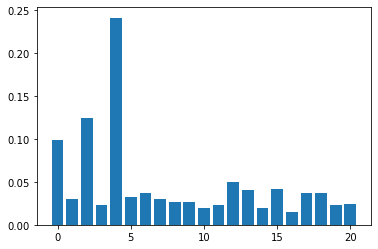

Wall time: 432 ms


In [25]:
%%time
# setting Random forest as sample to view data 
classifier = ExtraTreesRegressor()
clf = classifier.fit(X_train, y_train)
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

features = clf.feature_importances_
print(features)
plt.bar(x = range(len(features)), height=features)
plt.show()

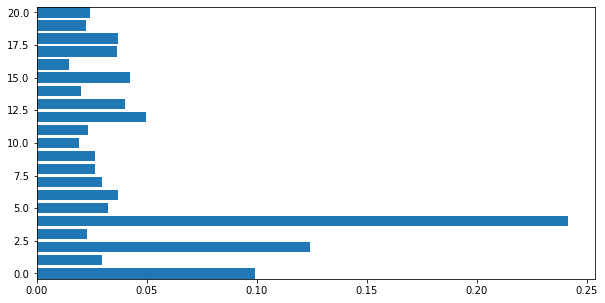

Wall time: 142 ms


In [26]:
%%time
features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()
fig.set_size_inches(10,5)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

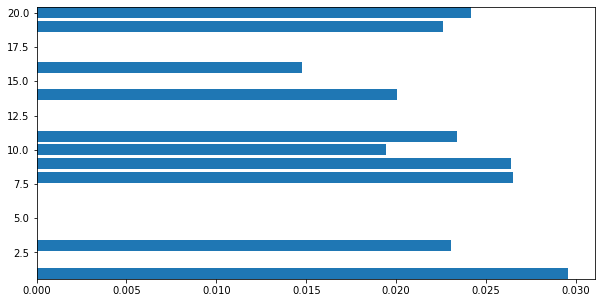

Wall time: 128 ms


In [27]:
%%time
features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
features = features[:10]
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()
fig.set_size_inches(10,5)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [28]:
y_predicted = clf.predict(X_test)
scores = clf.score(X_test, y_test)

print(y_predicted)
print(scores)

[ 36.40428337  44.58168059  55.8570631   64.75041386  44.13234111
  73.94641676  74.02727931  50.66054263  46.74565767  52.63619752
   6.82348901  46.94819802  70.43408954  31.55250511  58.18426417
  70.4053195   11.9227578   48.56449971  45.97493821  77.40343342
   8.77421429  81.3436745   64.11771932  59.04369582   6.96036191
  30.21618451  66.62147616  30.66670404  72.36382391  37.76036492
  31.22888741  71.6065985   54.23497421  67.35802706  97.65947003
  24.47708608  34.77796668  48.15792523  23.31560775  51.20859627
  73.71114556  16.64416996  84.03823002  89.14003297  79.41759337
  24.45212153  68.45469818  45.28458058 102.51002249  55.75237361
  71.45556585  65.08953102  25.98069947  78.22274772  46.69778175
  27.02884783  66.96047767  57.76801209  53.44230254  65.89204492
  98.28764166  77.16336221  82.89932312  82.49495018  92.35685901
  69.18009879  13.13872605  80.02604894  50.72454352  70.44037758
  24.28716709  44.31694815  61.65119245  45.28379172  67.21850501
  78.08053

In [29]:
y_predicted = clf.predict(X)
print(y_predicted)

[ 77.16336221  84.16        89.14003297  36.85355649  39.35
 101.38181818  71.09476309  60.59395973 121.11483254  81.3436745
  85.69863014  82.49495018  79.7944664   80.56637168  61.08296943
  61.29232442  95.1959799  144.16161616  61.65119245  82.88968295
  51.05022831  84.62222222  69.18009879  89.57692308  90.12765957
  68.4047619   69.59695817  73.23509934  83.4673913   71.26556017
  30.66670404  54.49637681  88.68202765  66.96047767  87.87439614
  67.21311475  79.41818182  70.84057971  65.60498221  65.98298085
  49.57432432  90.14634146  85.22767857  84.78205128  50.
  72.37668161  74.55108057  68.79324895  45.91549296  76.21978022
  48.57931034  76.13372093  70.31111111  64.          90.6122449
  73.94641676  67.83951686  84.          16.1627907   94.77272727
  43.04761905  79.          63.22834646  84.03823002  90.17045455
  54.81666667  54.71698113  54.31578947  98.28764166  64.92954538
  77.40343342  75.          70.44037758  67.35802706 105.95555556
  77.56417745  50.66054263

In [30]:
adp_scope['Prediction'] = y_predicted

In [31]:
adp_scope.sort_values('Prediction', ascending=False).head(50)

,Player,2019 FantasyPoints,2020 FantasyPoints,2021 FantasyPoints,Production21,Average Total Production,Team,POS,AVG,Prediction
294,Andre Roberts,5.70,-1.0,7.0,288.0,124.922222,NaN,NaN,NaN,288.000000
412,Nick Bawden,5.70,0.0,2.0,180.0,69.444444,NaN,NaN,NaN,180.000000
406,Jakob Johnson,1.50,10.0,4.0,146.2,73.4,NaN,NaN,NaN,146.200000
17,Deebo Samuel,187.10,48.0,262.0,144.161616,95.756771,SF,WR7,19.0,144.161616
233,DeSean Jackson,36.90,31.0,56.0,136.296296,64.280783,NaN,NaN,NaN,136.296296
298,Alex Erickson,96.24,11.0,6.0,133.571429,96.145734,NaN,NaN,NaN,133.571429
153,Kendrick Bourne,95.80,81.0,126.0,126.48,95.517284,NE,WR90,254.0,126.480000
8,Ja'Marr Chase,0.00,0.0,224.0,121.114833,40.371611,CIN,WR3,9.3,121.114833
363,Demetric Felton,0.00,0.0,33.0,118.285714,39.428571,NaN,NaN,NaN,118.285714
353,Travis Homer,28.00,24.0,46.0,115.756098,83.175535,NaN,NaN,NaN,115.756098


In [32]:
# save
joblib.dump(classifier, "Resources/draft_position_no_QB.joblib")

# Temporary write file while we are working on data ***

adp_scope.to_csv('Resources/Draft_position_no_QB.csv')

### <span style='color:green '>The section below is to evaluate new potential Models </scan>

In [33]:
# # Create X (features) and y (target) sets
# X = pf

# #convert y values to categorical values(for model selection matrix)
# lab = preprocessing.LabelEncoder()
# y_transformed = lab.fit_transform(y)
# y = y_transformed

# # Split the data into training and testing sets
# data = X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [34]:
# %%time
# # call function test_model to test all models being considered
# test_model(data)

In [35]:
# # Print by Training Score
# df_scores = pd.DataFrame(scores, index=index)
# df_scores.sort_values('Train Score', ascending=False).head(10)
# # Print by Testing Score
# df_scores.sort_values('Test Score', ascending=False).head(10)
# # Print by Testing Score
# df_scores['Test Train Magnitude'] = abs(df_scores['Test Train Difference'])
# df_scores.sort_values('Test Train Magnitude').head(10)